### Cleaning Scheduled Rent
The Strategy is use the current tiers as a benchmark to determine if the scheduled rent is correct, needs to be divided by bedrooms or needs to be replaced entirely

In [41]:
import pandas as pd
import numpy as np
import os

average_prices_df = pd.read_excel("Average Prices.xlsx", sheet_name=None)   
ash_properties = ["1Eleven", "308_King", "Bridgeport_House", "Fergus_House", "Preston_House", "King_Street_Towers", "Hespeler_House", "MyRez_on_Lester", "417Nelson", "See-More"]

def build_price_lookup(avg_prices_obj, property_name="1Eleven", prop_col="Property", type_col="Bedroom Type", price_col="Average Price"):
        if isinstance(avg_prices_obj, dict):
            if property_name in avg_prices_obj:
                dfp = avg_prices_obj[property_name].copy()
            else:
                dfp = pd.concat(avg_prices_obj.values(), ignore_index=True)
        else:
            dfp = avg_prices_obj.copy()

        dfp.columns = [str(c).strip() for c in dfp.columns]
        if prop_col in dfp.columns:
            dfp = dfp[dfp[prop_col].astype(str).str.strip().str.casefold() == property_name.casefold()]

        dfp[type_col] = dfp[type_col].astype(str).str.strip().str.upper()
        dfp[price_col] = pd.to_numeric(dfp[price_col], errors="coerce")

        price_map = dfp.groupby(type_col)[price_col].median().dropna().to_dict()
        return price_map

def clean_scheduled_rent(df, price_lookup, unit_col="Unit Type", rent_col="Scheduled Rent", bed_col="Bedroom Count", tolerance_pct=0.10, tolerance_abs=50):
        out = df.copy()

        out[rent_col] = pd.to_numeric(out[rent_col], errors="coerce")
        out[bed_col] = pd.to_numeric(out[bed_col], errors="coerce")
        out["_UNIT_KEY"] = out[unit_col].astype(str).str.strip().str.upper()

        out["expected_rent"] = out["_UNIT_KEY"].map(price_lookup)

        has_rent = out[rent_col].notna() & (out[rent_col] > 0)
        has_expected = out["expected_rent"].notna()
        mask = has_rent & has_expected

        out["scheduled_rent_cleaned"] = out[rent_col]
        out["clean_reason"] = np.where(mask, "as_is_check", "not_checked")

        # Check if the scheduled rent is reasonably close to what our tiers are
        def close_enough(given, expected):
            return (given - expected).abs() <= np.maximum(tolerance_abs, tolerance_pct * expected)

        given = out.loc[mask, rent_col]
        expected = out.loc[mask, "expected_rent"]
        within_now = close_enough(given, expected)

        out.loc[mask & within_now, "clean_reason"] = "kept_as_is"

        to_try_perbed = mask & ~within_now.reindex(out.index, fill_value=False)

        # Divide by number of bedrooms and see if that was the issue
        perbed = out.loc[to_try_perbed, rent_col] / out.loc[to_try_perbed, bed_col].replace(0, np.nan)
        perbed_within = close_enough(perbed, out.loc[to_try_perbed, "expected_rent"])

        out.loc[to_try_perbed & perbed_within.reindex(out.index, fill_value=False), "scheduled_rent_cleaned"] = perbed
        out.loc[to_try_perbed & perbed_within.reindex(out.index, fill_value=False), "clean_reason"] = "divided_by_bedrooms"

        still_off = to_try_perbed & ~perbed_within.reindex(out.index, fill_value=False)
        out.loc[still_off, "scheduled_rent_cleaned"] = out.loc[still_off, "expected_rent"]
        
        # If dividing still didn't work, replace with average (tier value for bedroom type)
        out.loc[still_off, "clean_reason"] = "replaced_with_average"

        # should never happen, but just in case
        out.loc[has_rent & ~has_expected, "clean_reason"] = "no_match_in_average_prices"
        out.drop(columns=["_UNIT_KEY"], inplace=True)
        
        return out

for property in ash_properties:
    csv_path = f"Properties/{property}_filtered_output.csv"         
    temp_df = pd.read_csv(csv_path)

    property_formatted = property.replace("_", " ")    
    price_lookup = build_price_lookup(average_prices_df, property_name=property_formatted)
    
    temp_df_cleaned = clean_scheduled_rent(temp_df, price_lookup, unit_col="Unit Type", rent_col="Scheduled Rent", bed_col="Bedroom Count", tolerance_pct=0.50, tolerance_abs=500)
    cleaned_csv_path = f"Properties_Cleaned_Rent/{property}_cleaned.csv"
    
    temp_df_cleaned.to_csv(cleaned_csv_path, index=False)


C:\Users\JackE\AppData\Local\Temp\ipykernel_24716\1432881637.py:76: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(csv_path)
C:\Users\JackE\AppData\Local\Temp\ipykernel_24716\1432881637.py:76: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(csv_path)
C:\Users\JackE\AppData\Local\Temp\ipykernel_24716\1432881637.py:76: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(csv_path)
C:\Users\JackE\AppData\Local\Temp\ipykernel_24716\1432881637.py:76: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(csv_path)
C:\Users\JackE\AppData\Local\Temp\ipykernel_24716\1432881637.py:76: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  te

### Google Reviews

In [42]:
'''
Taken directly from Google Reviews
'''
GoogleReviewStars = {
    "17Hundred": 3.5,
    "1Eleven": 3.8,
    "1Ten_on_Whyte": 4.2, 
    "308_King": 4.7,
    "417Nelson": 4.9,
    "ALMA_@_ByWard_Market": 4.0,  
    "ALMA_@_Guelph": 4.6,
    "ALMA_@_Oshawa": 3.8,
    "ALMA_@_Shaughnessy_Village": 3.8,
    "ALMA_Latin_Quartier": 5.0,
    "ALMA_Sandy_Hill": 4.2,
    "Bridgeport_House": 3.9,
    "Fergus_House": 4.1,
    "Hespeler_House": 4.0,
    "King_Street_Towers": 3.9,
    "MyRez_on_Lester": 4.1,
    "Preston_House": 4.0,
    "See-More": 4.7,
    "The_Arc": 4.0,
    "The_Quad_at_York_Phase_1": 3.6, 
    "The_Quad_at_York_Phase_2": 3.6,
    "West_Village_Suites": 3.1,
    "Woodroffe_Place": 3.9
}

In [43]:
files = os.listdir("Properties_Cleaned_Rent")

results = []
for file in files:
    temp_df = pd.read_csv("Properties_Cleaned_Rent/"+file, low_memory=False)
    property_name = file.replace("_cleaned", "").split('.')[0]
    temp_df = temp_df[temp_df["Event Date"] >= "2025-01-01"]
    avg_revenue_property = temp_df["scheduled_rent_cleaned"].mean()
    results.append({
        "PropertyName": property_name,
        "AvgRevenue": avg_revenue_property,
        "GoogleReviewStars": GoogleReviewStars.get(property_name, None)
    })

property_summary = pd.DataFrame(results)
property_summary = property_summary[property_summary["AvgRevenue"].notna()]
property_summary

,PropertyName,AvgRevenue,GoogleReviewStars
0,1Eleven,1161.944970,3.8
1,308_King,1263.273426,4.7
2,417Nelson,1371.966589,4.9
3,Bridgeport_House,987.961895,3.9
4,Fergus_House,1037.346062,4.1
5,Hespeler_House,1169.011454,4.0
6,King_Street_Towers,971.458261,3.9
7,MyRez_on_Lester,1032.703571,4.1
8,Preston_House,1024.019710,4.0
9,See-More,1109.244073,4.7


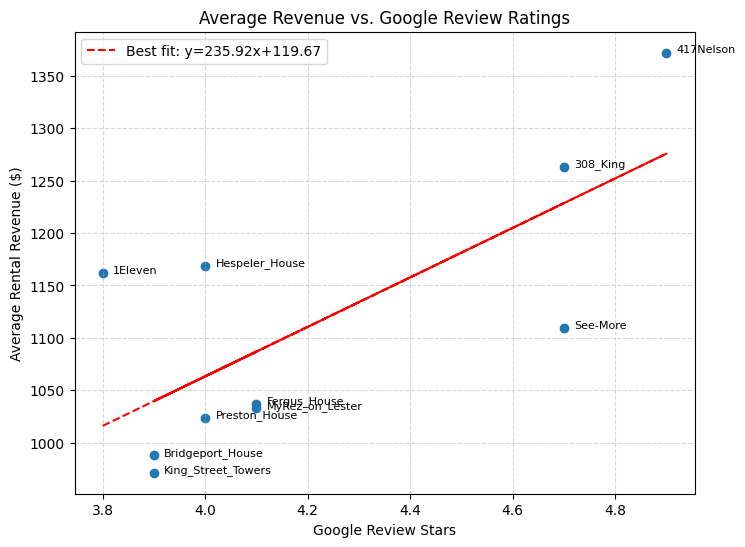

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(property_summary["GoogleReviewStars"], property_summary["AvgRevenue"])

# Labels
for i, row in property_summary.iterrows():
    plt.text(row["GoogleReviewStars"]+0.02, row["AvgRevenue"], row["PropertyName"], fontsize=8)

# Best-fit line
x = property_summary["GoogleReviewStars"]
y = property_summary["AvgRevenue"]

# Fit a straight line (degree=1 polynomial)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="red", linestyle="--", label=f"Best fit: y={m:.2f}x+{b:.2f}")

plt.xlabel("Google Review Stars")
plt.ylabel("Average Rental Revenue ($)")
plt.title("Average Revenue vs. Google Review Ratings")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


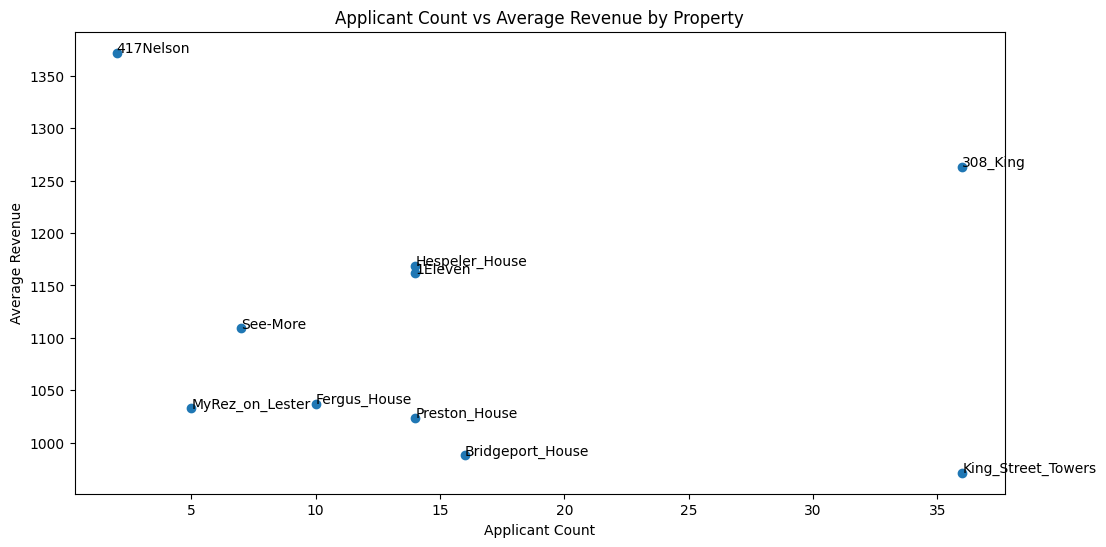

In [45]:
# Replace spaces with underscores in the property column
currentApplicantsdf = pd.read_csv("Current Applicants.csv")
currentApplicantsdf["Property"] = currentApplicantsdf["Property"].str.replace(" ", "_")

# Now count again
property_counts = currentApplicantsdf["Property"].value_counts()

property_counts_df = property_counts.reset_index()
property_counts_df.columns = ["PropertyName", "ApplicantCount"]
property_counts_df["PropertyName"] = property_counts_df["PropertyName"].astype(str)
merged_df = pd.merge(property_counts_df, property_summary, on="PropertyName", how="left")

plt.figure(figsize=(12,6))
plt.scatter(merged_df["ApplicantCount"], merged_df["AvgRevenue"])

for i, txt in enumerate(merged_df["PropertyName"]):
    plt.annotate(txt, (merged_df["ApplicantCount"].iloc[i], merged_df["AvgRevenue"].iloc[i]))

plt.xlabel("Applicant Count")
plt.ylabel("Average Revenue")
plt.title("Applicant Count vs Average Revenue by Property")
plt.show()

In [46]:
floors_per_building = {
    "17Hundred": 6, # divided up into 6 storeys and 4 storeys
    "1Eleven": 16,
    "1Ten_on_Whyte": 4,
    "308_King": 25,
    "417Nelson": 31,
    "ALMA_@_ByWard_Market": 15,
    "ALMA_@_Guelph": 7, # Two 7-storey buildings
    "ALMA_@_Oshawa": 9,
    "ALMA_@_Shaughnessy_Village": 18,
    "ALMA_Latin_Quartier": 3,
    "ALMA_Sandy_Hill": 6,
    "Bridgeport_House": 18,
    "Fergus_House": 21,
    "Hespeler_House": 21,
    "King_Street_Towers": 21, # two towers - one with 17 floors and one with 21 floors
    "MyRez_on_Lester": 18,
    "Preston_House": 17,
    "See-More": 16,
    "The_Arc": 15,
    "The_Quad_at_York_Phase_1": 7,
    "The_Quad_at_York_Phase_2": 6,
    "West_Village_Suites": 9,
    "Woodroffe_Place": 16
}

In [47]:
building_counts = []
files = os.listdir("Properties_Cleaned_Rent")
for file in files:
    df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
    df_temp = df_temp[df_temp["scheduled_rent_cleaned"] >= 0].dropna(subset=["Unit Space ID"])

    # get 2025 data for a more recent average
    df_temp = df_temp[df_temp["Event Date"] >= "2025-01-01"]
    unique_amt = df_temp["Unit Space ID"].nunique()
    avg_rent = df_temp["scheduled_rent_cleaned"].mean()
    building_name = os.path.basename(file).replace("_cleaned.csv", "")
    floors = floors_per_building[building_name]
    avg_units_per_floor = unique_amt / floors
    building_counts.append({"Building": building_name, "Count": unique_amt, "Floors": floors, "AvgRent": avg_rent, "Average Units Per Floor": avg_units_per_floor})

building_counts_df = pd.DataFrame(building_counts)
building_counts_df

C:\Users\JackE\AppData\Local\Temp\ipykernel_24716\2279804079.py:4: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
C:\Users\JackE\AppData\Local\Temp\ipykernel_24716\2279804079.py:4: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
C:\Users\JackE\AppData\Local\Temp\ipykernel_24716\2279804079.py:4: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
C:\Users\JackE\AppData\Local\Temp\ipykernel_24716\2279804079.py:4: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
C:\Users\JackE\AppData\Local\Temp\ipykernel_24716\2279804079.py:4: DtypeWarning: Columns

,Building,Count,Floors,AvgRent,Average Units Per Floor
0,1Eleven,357,16,1161.944970,22.312500
1,308_King,492,25,1263.273426,19.680000
2,417Nelson,91,31,1371.966589,2.935484
3,Bridgeport_House,480,18,987.961895,26.666667
4,Fergus_House,476,21,1037.346062,22.666667
5,Hespeler_House,476,21,1169.011454,22.666667
6,King_Street_Towers,933,21,971.458261,44.428571
7,MyRez_on_Lester,444,18,1032.703571,24.666667
8,Preston_House,296,17,1024.019710,17.411765
9,See-More,489,16,1109.244073,30.562500


### Unit Count

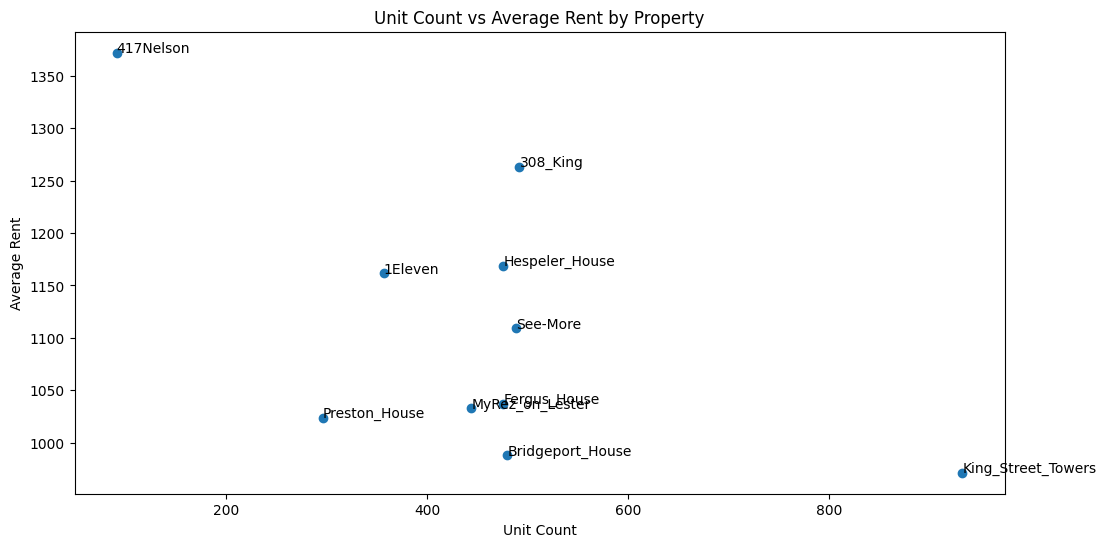

In [48]:
plt.figure(figsize=(12,6))
plt.scatter(building_counts_df["Count"], building_counts_df["AvgRent"])

for i, txt in enumerate(building_counts_df["Building"]):
    plt.annotate(txt, (building_counts_df["Count"].iloc[i], building_counts_df["AvgRent"].iloc[i]))

plt.xlabel("Unit Count")
plt.ylabel("Average Rent")
plt.title("Unit Count vs Average Rent by Property")
plt.show()

### Number of Floors

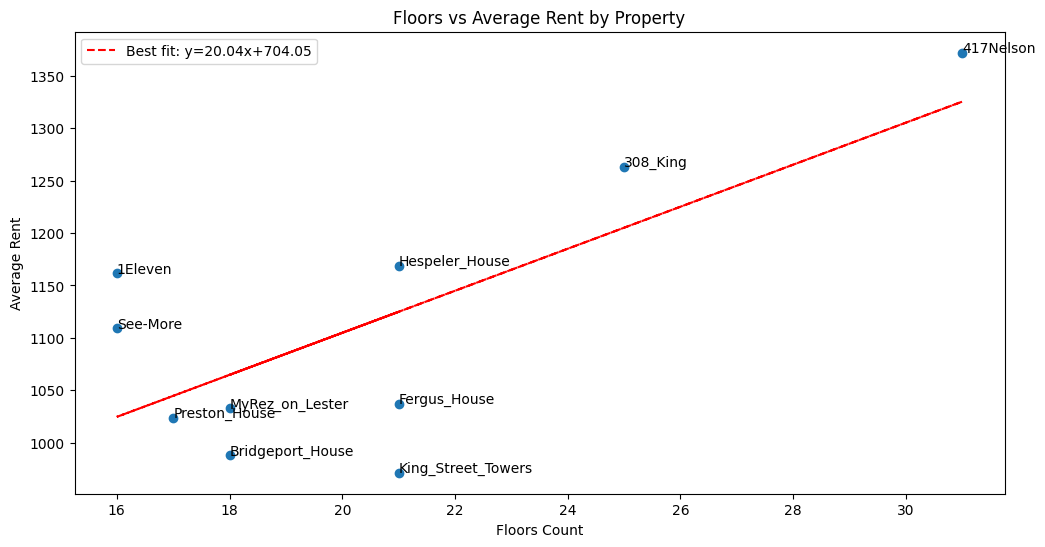

Best fit line: y = 20.04x + 704.05 (p-value: 0.0182)


In [49]:
from scipy.stats import linregress

plt.figure(figsize=(12,6))
plt.scatter(building_counts_df["Floors"], building_counts_df["AvgRent"])

# Annotate each point
for i, txt in enumerate(building_counts_df["Building"]):
    plt.annotate(txt, (building_counts_df["Floors"].iloc[i], building_counts_df["AvgRent"].iloc[i]))

# Line of best fit
x = building_counts_df["Floors"]
y = building_counts_df["AvgRent"]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, slope*x + intercept, color="red", linestyle="--", label=f"Best fit: y={slope:.2f}x+{intercept:.2f}")

plt.xlabel("Floors Count")
plt.ylabel("Average Rent")
plt.title("Floors vs Average Rent by Property")
plt.legend()
plt.show()

print(f"Best fit line: y = {slope:.2f}x + {intercept:.2f} (p-value: {p_value:.4f})")

### Building Age

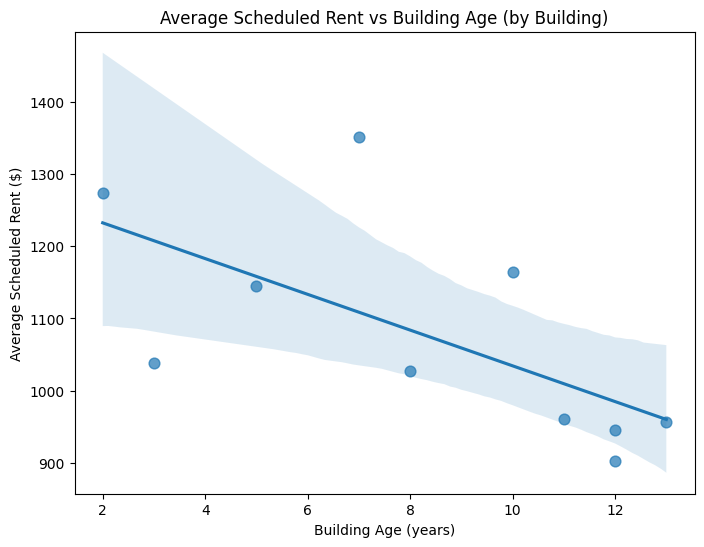

(             Building  Age      AvgRent
 0             1Eleven   10  1164.000668
 1            308_King    2  1274.358720
 2           417Nelson    7  1350.840376
 3    Bridgeport_House   12   944.945791
 4        Fergus_House    8  1027.493853
 5      Hespeler_House    5  1145.286932
 6  King_Street_Towers   12   902.450899
 7     MyRez_on_Lester   11   960.851125
 8       Preston_House   13   956.748046
 9            See-More    3  1037.786264,
 {'Line': 'Rent = -24.75 * Age + 1281.89',
  'R²': 0.4165395528540049,
  'p-value': 0.04386732089767918})

In [50]:
import os
from glob import glob
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

directory = os.getcwd()
files = os.listdir("Properties_Cleaned_Rent")
building_stats = []
for file in files:
    df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file, low_memory=False)
    df_temp = df_temp.dropna(subset=["scheduled_rent_cleaned", "Property Year Built"])
    df_temp = df_temp[df_temp["scheduled_rent_cleaned"] > 0]
    age = 2025 - df_temp["Property Year Built"].iloc[0]
    avg_rent = df_temp["scheduled_rent_cleaned"].mean()
    building_name = os.path.basename(file).replace("_cleaned.csv", "")
    building_stats.append({"Building": building_name, "Age": age, "AvgRent": avg_rent})

building_stats_df = pd.DataFrame(building_stats)

slope, intercept, r_value, p_value, std_err = stats.linregress(
    building_stats_df["Age"], building_stats_df["AvgRent"]
)

regression_results = {
    "Line": f"Rent = {slope:.2f} * Age + {intercept:.2f}",
    "R²": r_value**2,
    "p-value": p_value
}

plt.figure(figsize=(8,6))
sns.regplot(data=building_stats_df, x="Age", y="AvgRent", scatter_kws={'s':60, 'alpha':0.7})
plt.title("Average Scheduled Rent vs Building Age (by Building)")
plt.xlabel("Building Age (years)")
plt.ylabel("Average Scheduled Rent ($)")
plt.show()

building_stats_df, regression_results

### Walkscore

In [51]:
walkscore_data = pd.read_excel("WalkScore.xlsx")
walkscore_data_filtered = walkscore_data[walkscore_data["Property"].isin(ash_properties)]
walkscore_data_filtered

,Property,WalkScore,Good Transit,Bikeable
1,1Eleven,98,90,95
3,308_King,87,62,75
4,417Nelson,96,87,97
11,Bridgeport_House,87,62,75
12,Fergus_House,79,70,93
13,Hespeler_House,79,68,93
14,King_Street_Towers,87,64,76
15,MyRez_on_Lester,82,70,93
16,Preston_House,87,63,76
17,See-More,93,67,77


In [52]:
merged_df = pd.merge(building_stats_df, walkscore_data_filtered, left_on="Building", right_on="Property", how="left")
merged_df

,Building,Age,AvgRent,Property,WalkScore,Good Transit,Bikeable
0,1Eleven,10,1164.000668,1Eleven,98,90,95
1,308_King,2,1274.358720,308_King,87,62,75
2,417Nelson,7,1350.840376,417Nelson,96,87,97
3,Bridgeport_House,12,944.945791,Bridgeport_House,87,62,75
4,Fergus_House,8,1027.493853,Fergus_House,79,70,93
5,Hespeler_House,5,1145.286932,Hespeler_House,79,68,93
6,King_Street_Towers,12,902.450899,King_Street_Towers,87,64,76
7,MyRez_on_Lester,11,960.851125,MyRez_on_Lester,82,70,93
8,Preston_House,13,956.748046,Preston_House,87,63,76
9,See-More,3,1037.786264,See-More,93,67,77


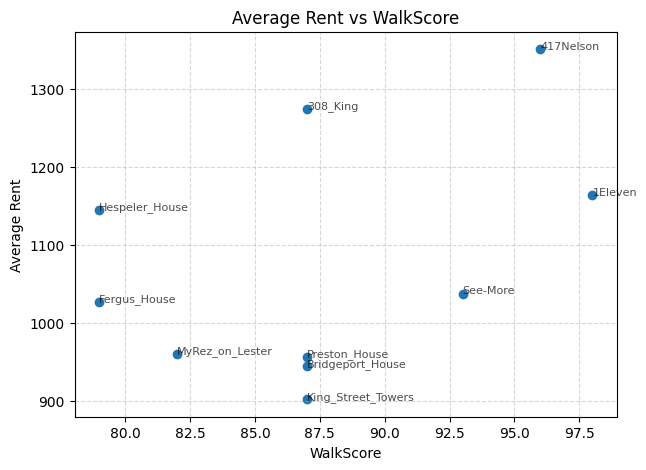

Correlation between WalkScore and AvgRent: 0.40 (p-value: 0.2462)


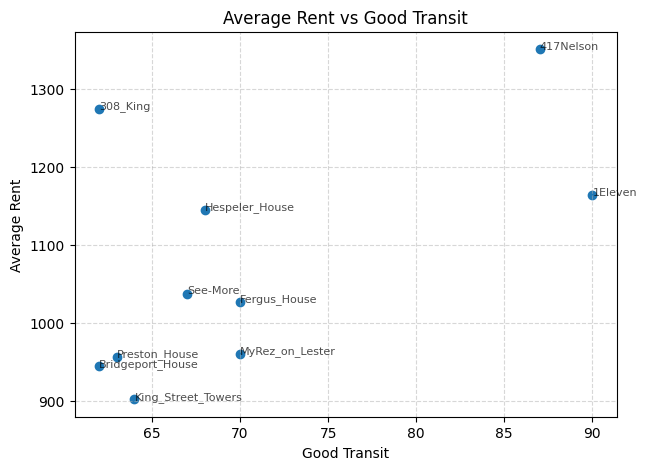

Correlation between Good Transit and AvgRent: 0.56 (p-value: 0.0892)


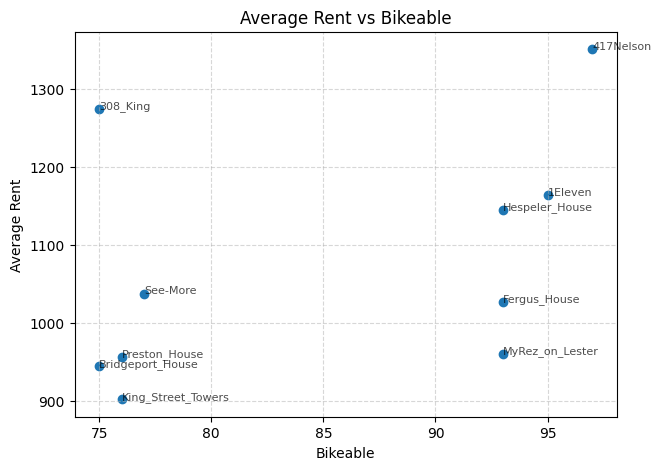

Correlation between Bikeable and AvgRent: 0.43 (p-value: 0.2184)


In [53]:
from scipy.stats import pearsonr
# List of WalkScore-related columns to check
score_cols = ["WalkScore", "Good Transit", "Bikeable"]

for col in score_cols:
    if col in merged_df.columns:
        plt.figure(figsize=(7,5))
        plt.scatter(merged_df[col], merged_df["AvgRent"])
        # Annotate each point with the building name
        for i, txt in enumerate(merged_df["Building"]):
            plt.annotate(
                txt,
                (merged_df[col].iloc[i], merged_df["AvgRent"].iloc[i]),
                fontsize=8,
                alpha=0.7
            )
        plt.xlabel(col)
        plt.ylabel("Average Rent")
        plt.title(f"Average Rent vs {col}")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
        # Print correlation and p-value
        x = merged_df[col]
        y = merged_df["AvgRent"]
        corr, pval = pearsonr(x, y)
        print(f"Correlation between {col} and AvgRent: {corr:.2f} (p-value: {pval:.4f})")

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import numpy as np

walk_cols = ["WalkScore", "Good Transit", "Bikeable"]
mlr_df = merged_df.dropna(subset=walk_cols + ["AvgRent"])

X = mlr_df[walk_cols]
y = mlr_df["AvgRent"]

rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X, y)

importances = rf.feature_importances_
for col, imp in zip(walk_cols, importances):
    print(f"{col} importance: {imp:.3f}")

cv_r2 = cross_val_score(rf, X, y, cv=5, scoring='r2')
print(f"Random Forest CV R^2: {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")

y_pred = rf.predict(X)
print(f"Train R^2: {r2_score(y, y_pred):.3f}")

WalkScore importance: 0.278
Good Transit importance: 0.371
Bikeable importance: 0.351
Random Forest CV R^2: -6.844 ± 6.684
Train R^2: 0.677


### Clean Leases (after Cleaning Scheduled Rent)

In [55]:
files = os.listdir("Properties_Cleaned_Rent")
cleaned_leases_rent_directory = "Properties_Cleaned_Leases_Rent"

for file in files:
    temp_df = pd.read_csv("Properties_Cleaned_Rent/"+file, low_memory=False)
    
    # Drop rows with missing dates (i.e. cannot compute lease length)
    temp_df = temp_df.dropna(subset=["Lease Start Date", "Lease End Date"])
    
    # Convert datetime
    temp_df["Lease Start Date"] = pd.to_datetime(temp_df["Lease Start Date"], errors="coerce")
    temp_df["Lease End Date"] = pd.to_datetime(temp_df["Lease End Date"], errors="coerce")
    
    # Ensure start < end
    temp_df = temp_df.dropna(subset=["Lease Start Date", "Lease End Date"])
    temp_df = temp_df[temp_df["Lease Start Date"] < temp_df["Lease End Date"]]

    temp_df["LeaseLengthYears"] = ((temp_df["Lease End Date"] - temp_df["Lease Start Date"]).dt.days / 365.25).round()
    temp_df["LeaseLengthMonths"] = ((temp_df["Lease End Date"] - temp_df["Lease Start Date"]).dt.days / 30.44).round()

    temp_df.to_csv(f"{cleaned_leases_rent_directory}/{file}", index=False)

### Analyze Lease Length (years)
Start with first week of September for simplicity

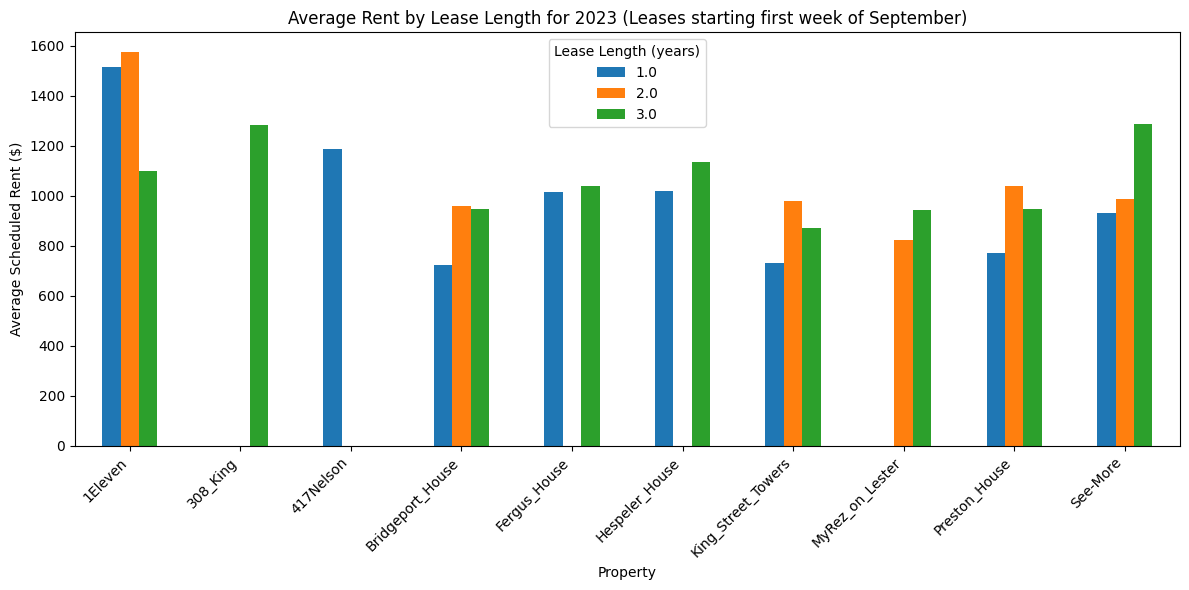

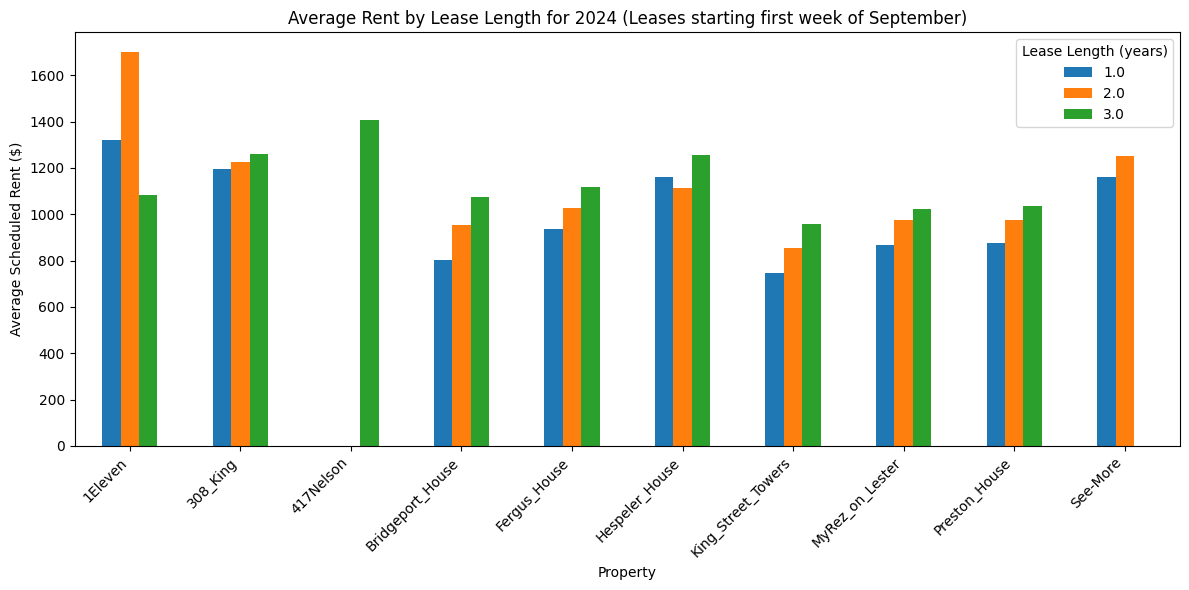

In [ ]:
directory = "Properties_Cleaned_Leases_Rent"
files = os.listdir(directory)

results = []

# Define years
years_to_check = [2023, 2024, 2025]

for file in files:
    df = pd.read_csv(os.path.join(directory, file), parse_dates=["Lease Start Date"])
    df["Event Date"] = pd.to_datetime(df["Event Date"], errors="coerce")
    df = df[df["Event Date"] >= "2025-01-01"]
    property_name = file.replace("_cleaned.csv", "")
    for year in years_to_check:
        # Find first week of September for the given year
        sept_start = pd.Timestamp(f"{year}-09-01")
        sept_end = pd.Timestamp(f"{year}-09-07")
        # Filter for leases starting within the first week of September
        filtered = df[(df["Lease Start Date"] >= sept_start) & (df["Lease Start Date"] <= sept_end)]
        if not filtered.empty:
            summary = filtered.groupby("LeaseLengthYears")["scheduled_rent_cleaned"].mean().reset_index()
            summary["Property"] = property_name
            summary["Year"] = year
            results.append(summary)

# Combine all properties and years
all_results = pd.concat(results, ignore_index=True)
all_results = all_results[(all_results["LeaseLengthYears"] > 0) & (all_results["LeaseLengthYears"] <= 3)]
# See which lease lengths yield highest rent per property per year
highest = all_results.loc[all_results.groupby(["Property", "Year"])["scheduled_rent_cleaned"].idxmax()]

for year in years_to_check:
    df_year = all_results[all_results["Year"] == year]
    if df_year.empty:
        continue
    pivot = df_year.pivot(index="Property", columns="LeaseLengthYears", values="scheduled_rent_cleaned")
    pivot = pivot[[1.0, 2.0, 3.0]] if set([1.0,2.0,3.0]).issubset(pivot.columns) else pivot
    ax = pivot.plot(kind="bar", figsize=(12,6))
    ax.set_title(f"Average Rent by Lease Length for {year} (Leases starting first week of September)")
    ax.set_xlabel("Property")
    ax.set_ylabel("Average Scheduled Rent ($)")
    ax.legend(title="Lease Length (years)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [57]:
all_results

,LeaseLengthYears,scheduled_rent_cleaned,Property,Year
1,1.0,1515.000000,1Eleven,2023
2,2.0,1575.345817,1Eleven,2023
3,3.0,1097.679188,1Eleven,2023
5,1.0,1322.105357,1Eleven,2024
6,2.0,1700.000000,1Eleven,2024
7,3.0,1082.014760,1Eleven,2024
10,3.0,1282.334958,308_King,2023
12,1.0,1195.000000,308_King,2024
13,2.0,1226.010518,308_King,2024
14,3.0,1259.795381,308_King,2024


### Proximity Exploratory Analysis
Choose Waterloo for now as that was the "agreed upon pilot city" and also all these buildings are in the ASH Pricing Strategy

In [58]:
merged_df_waterloo = merged_df[merged_df["Property"].isin(["Bridgeport_House", "Fergus_House", "Hespeler_House", "King_Street_Towers", "MyRez_on_Lester", "Preston_House", "308_King"])]

In [59]:
merged_df_waterloo

,Building,Age,AvgRent,Property,WalkScore,Good Transit,Bikeable
1,308_King,2,1274.358720,308_King,87,62,75
3,Bridgeport_House,12,944.945791,Bridgeport_House,87,62,75
4,Fergus_House,8,1027.493853,Fergus_House,79,70,93
5,Hespeler_House,5,1145.286932,Hespeler_House,79,68,93
6,King_Street_Towers,12,902.450899,King_Street_Towers,87,64,76
7,MyRez_on_Lester,11,960.851125,MyRez_on_Lester,82,70,93
8,Preston_House,13,956.748046,Preston_House,87,63,76


In [60]:
waterloo_buildings_coords = pd.DataFrame({
    "Building": ["Bridgeport_House", "Fergus_House", "Hespeler_House", "King_Street_Towers", "MyRez_on_Lester", "Preston_House", "308_King"],
    "Latitude": [43.47982, 43.47274, 43.47274, 43.4797, 43.47123, 43.47884, 43.478444],
    "Longitude": [-80.52448, -80.53684, -80.53684, -80.52571, -80.53218, -80.52579, -80.524757]
})

merged_with_coords = merged_df_waterloo.merge(waterloo_buildings_coords, on="Building", how="left")
merged_with_coords

,Building,Age,AvgRent,Property,WalkScore,Good Transit,Bikeable,Latitude,Longitude
0,308_King,2,1274.358720,308_King,87,62,75,43.478444,-80.524757
1,Bridgeport_House,12,944.945791,Bridgeport_House,87,62,75,43.479820,-80.524480
2,Fergus_House,8,1027.493853,Fergus_House,79,70,93,43.472740,-80.536840
3,Hespeler_House,5,1145.286932,Hespeler_House,79,68,93,43.472740,-80.536840
4,King_Street_Towers,12,902.450899,King_Street_Towers,87,64,76,43.479700,-80.525710
5,MyRez_on_Lester,11,960.851125,MyRez_on_Lester,82,70,93,43.471230,-80.532180
6,Preston_House,13,956.748046,Preston_House,87,63,76,43.478840,-80.525790


### Proximity to Waterloo (Waterloo Properties)

C:\Users\JackE\AppData\Local\Temp\ipykernel_24716\141758054.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_with_coords[f"dist_{name}"] = haversine(


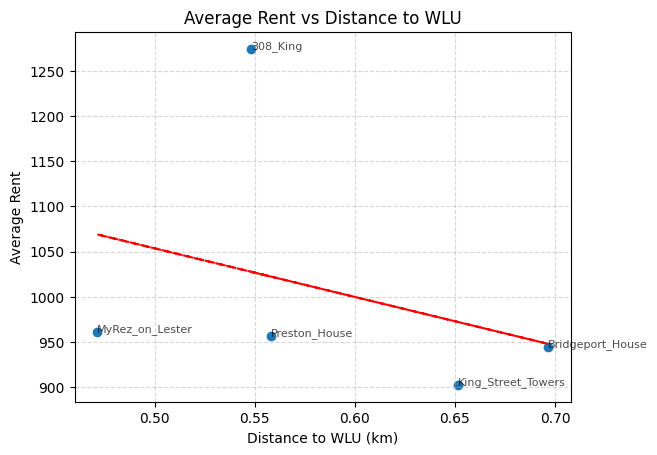

Slope: -537.95, p-value: 0.6013


In [ ]:
from scipy.stats import linregress

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c 

landmarks = {
    "uw_waterloo": (43.467796325683594, -80.54235076904297)
}

for name, (lat, lon) in landmarks.items():
    merged_with_coords[f"dist_{name}"] = haversine(
        merged_with_coords["Latitude"], merged_with_coords["Longitude"], lat, lon
    )

plt.scatter(merged_with_coords["dist_uw_waterloo"], merged_with_coords["AvgRent"])

for i, txt in enumerate(merged_with_coords["Building"]):
    plt.annotate(
        txt,
        (merged_with_coords["dist_uw_waterloo"].iloc[i], merged_with_coords["AvgRent"].iloc[i]),
        fontsize=8,
        alpha=0.7
    )

# Line of best fit
x = merged_with_coords["dist_uw_waterloo"]
y = merged_with_coords["AvgRent"]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, slope*x + intercept, color="red", linestyle="--", label=f"Best fit: y={slope:.2f}x+{intercept:.2f}")

plt.xlabel("Distance to UW (km)")
plt.ylabel("Average Rent")
plt.title(f"Average Rent vs Distance to UW")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f"Slope: {slope:.2f}, p-value: {p_value:.4f}")

In [ ]:
leadConversionDf = pd.read_csv(r"Input_Data/Lead Conversion.csv")
leadConversionDf["Property"] = leadConversionDf["Property"].str.replace(" ", "_")
property_summary["PropertyName"] = property_summary["PropertyName"].str.replace(" ", "_")

# Merge clean on same name
merged_df = pd.merge(
    leadConversionDf,
    property_summary.rename(columns={"PropertyName": "Property"}),
    on="Property",
    how="left"
)
merged_df.drop("Property.1", axis=1, inplace=True, errors="ignore")
merged_df = merged_df[merged_df["AvgRevenue"].notna()]
merged_df


,Property,New Lead,Leasing Events - First Visit/Tour,Application - Partially Completed,Application - Completed,Application - Approved,Lease - Completed,Lease - Approved,Cancelled - Prospect,Cancelled - Application Completed,Cancelled - Application Approved,Cancelled - Lease Completed,AvgRevenue,GoogleReviewStars
1,1Eleven,1065,68,6,132,100,96,98,825,7,30,1,1161.944970,3.8
3,308_King,1734,17,4,123,100,96,97,1560,14,11,2,1263.273426,4.7
4,417Nelson,1025,35,0,50,34,33,37,934,2,9,4,1371.966589,4.9
11,Bridgeport_House,554,6,1,48,41,40,39,453,6,3,1,987.961895,3.9
12,Fergus_House,478,1,2,96,93,92,91,352,7,3,0,1037.346062,4.1
13,Hespeler_House,853,4,4,140,125,124,128,648,9,11,3,1169.011454,4.0
14,King_Street_Towers,1722,19,12,150,118,112,112,1846,25,18,4,971.458261,3.9
15,MyRez_on_Lester,1237,6,2,119,86,86,91,1243,17,15,5,1032.703571,4.1
16,Preston_House,427,2,2,72,63,63,64,453,6,6,1,1024.019710,4.0
17,See-More,1891,54,18,170,106,102,103,1751,61,16,1,1109.244073,4.7


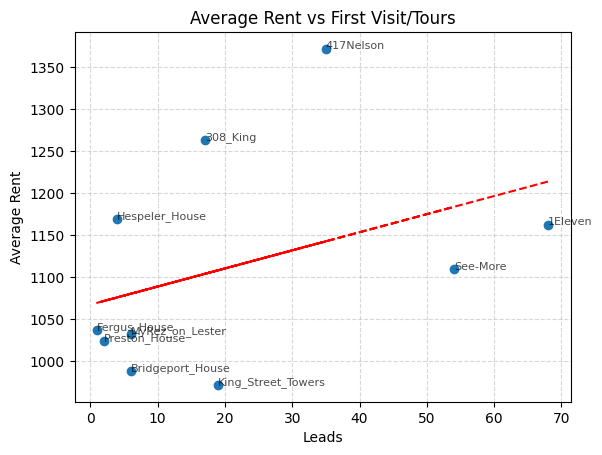

Slope: 2.16, p-value: 0.2610


In [ ]:
plt.scatter(merged_df["Leasing Events - First Visit/Tour"], merged_df["AvgRevenue"])

for i, txt in enumerate(merged_df["Property"]):
    plt.annotate(
        txt,
        (merged_df["Leasing Events - First Visit/Tour"].iloc[i], merged_df["AvgRevenue"].iloc[i]),
        fontsize=8,
        alpha=0.7
    )

# Line of best fit
x = merged_df["Leasing Events - First Visit/Tour"]
y = merged_df["AvgRevenue"]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, slope*x + intercept, color="red", linestyle="--", label=f"Best fit: y={slope:.2f}x+{intercept:.2f}")

plt.xlabel("Leads")
plt.ylabel("Average Rent")
plt.title(f"Average Rent vs First Visit/Tours (Jan 1 - Aug 6)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f"Slope: {slope:.2f}, p-value: {p_value:.4f}")

In [79]:
print(x.corr(y))

0.3931558910563838


In [ ]:
applicantsDf = pd.read_csv(r"Input_Data/Application Data.csv")
applicantsDf["Property"] = applicantsDf["Property"].str.replace(" ", "_")
counts_df = applicantsDf["Property"].value_counts().reset_index()
counts_df.columns = ["Property", "ApplicantCount"]
merged_df = pd.merge(
    counts_df,
    property_summary.rename(columns={"PropertyName": "Property"}),
    on="Property",
    how="left"
)
merged_df = merged_df[merged_df["AvgRevenue"].notna()]
merged_df

,Property,ApplicantCount,AvgRevenue,GoogleReviewStars
7,King_Street_Towers,214,971.458261,3.9
8,1Eleven,213,1161.944970,3.8
9,See-More,193,1109.244073,4.7
10,308_King,179,1263.273426,4.7
12,Hespeler_House,161,1169.011454,4.0
14,MyRez_on_Lester,147,1032.703571,4.1
16,Fergus_House,105,1037.346062,4.1
19,Preston_House,93,1024.019710,4.0
20,417Nelson,69,1371.966589,4.9
21,Bridgeport_House,58,987.961895,3.9


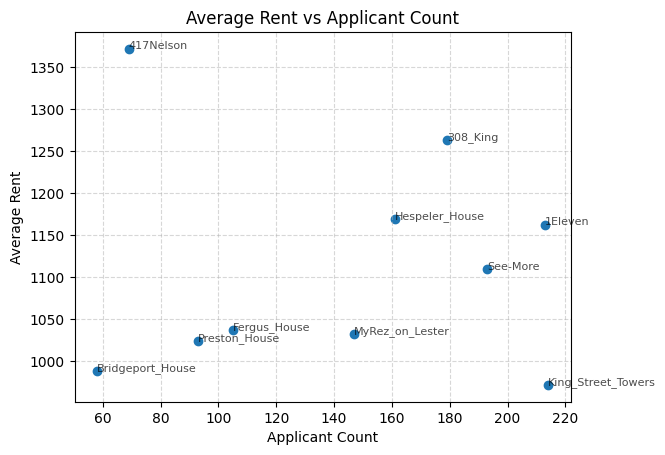

In [ ]:
plt.scatter(merged_df["ApplicantCount"], merged_df["AvgRevenue"])

for i, txt in enumerate(merged_df["Property"]):
    plt.annotate(
        txt,
        (merged_df["ApplicantCount"].iloc[i], merged_df["AvgRevenue"].iloc[i]),
        fontsize=8,
        alpha=0.7
    )

plt.xlabel("Applicant Count")
plt.ylabel("Average Rent")
plt.title(f"Average Rent vs Applicant Count (Jan 1 - Aug 6)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [4]:
import pandas as pd
leasingPerformanceDf = pd.read_csv(r"Input_Data/Leasing Performance.csv")
leasingPerformanceDf["Property"] = leasingPerformanceDf["Property"].str.replace(" ", "_")
leasingPerformanceDf

FileNotFoundError: [Errno 2] No such file or directory: 'Input_Data/Leasing Performance.csv'

In [5]:
import pandas as pd 
import numpy as np

leaseDatadf = pd.read_csv(r"Lease Data.csv")
leaseDatadf["Lease End"] = pd.to_datetime(leaseDatadf["Lease End"], errors="coerce")
leaseDatadf["Lease Start"] = pd.to_datetime(leaseDatadf["Lease Start"], errors="coerce")

# Need to do this in order to actually calculate descriptive stats
leaseDatadf["Scheduled Rent"] = (
    leaseDatadf["Scheduled Rent"]
    .replace({",": ""}, regex=True)   
    .astype(float)                    
)

leaseDatadf["Lease Length Years"] = round((leaseDatadf["Lease End"] - leaseDatadf["Lease Start"]).dt.days / 365.25)
leaseDatadf = leaseDatadf[leaseDatadf["Lease Length Years"] != 5]
leaseDatadf.groupby("Lease Length Years")["Scheduled Rent"].describe()


,count,mean,std,min,25%,50%,75%,max
Lease Length Years,,,,,,,,
0.0,30.0,1465.645333,631.482039,694.60,850.0000,1440.00,1975.6250,3294.40
1.0,367.0,1333.311417,776.393873,0.00,860.0000,1200.00,1718.8900,8282.00
2.0,60.0,1264.090667,738.588062,0.00,928.4025,1060.87,1591.0975,4018.65
3.0,455.0,1413.252725,856.674796,0.00,1009.6200,1200.00,1723.4400,6125.00
4.0,4.0,1255.600000,477.252770,922.50,1026.3000,1067.95,1297.2500,1964.00
6.0,21.0,1019.969048,48.490548,937.87,1040.0000,1040.00,1040.0000,1090.00


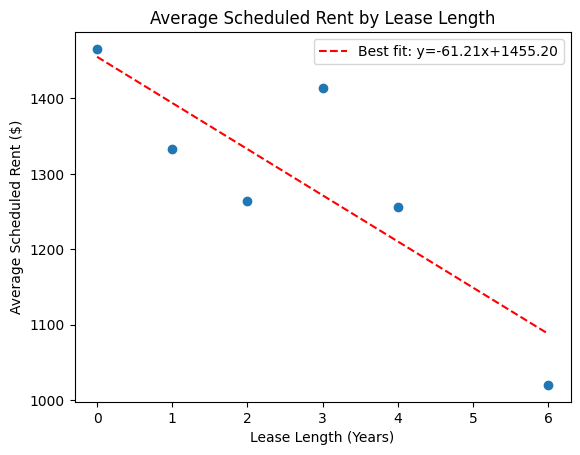

Slope: -61.21, p-value: 0.0345
R-squared: 0.713
y=-61.21x + 1455.20


In [6]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Collapse to one value per lease length
avg_rent = leaseDatadf.groupby("Lease Length Years")["Scheduled Rent"].mean().reset_index()

x = avg_rent["Lease Length Years"]
y = avg_rent["Scheduled Rent"]

# Scatter of averages
plt.scatter(x, y)

# Regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, slope*x + intercept, color="red", linestyle="--", label=f"Best fit: y={slope:.2f}x+{intercept:.2f}")

plt.xlabel("Lease Length (Years)")
plt.ylabel("Average Scheduled Rent ($)")
plt.title("Average Scheduled Rent by Lease Length")
plt.legend()
plt.show()
print(f"Slope: {slope:.2f}, p-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"y={slope:.2f}x + {intercept:.2f}")

### Lease Start/End Date
Starting with month for now, extending to actual day of month might prove tricky

In [7]:
leaseDatadf["Start Month"] = leaseDatadf["Lease Start"].dt.month
leaseDatadf["End Month"] = leaseDatadf["Lease End"].dt.month


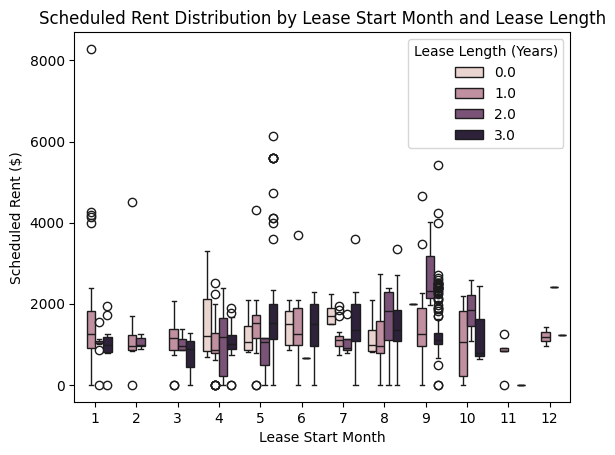

In [17]:
filtered = leaseDatadf[leaseDatadf["Lease Length Years"].isin([0, 1, 2, 3])]
start_month_length = (
    filtered
    .groupby(["Lease Length Years", "Start Month"])["Scheduled Rent"]
    .mean()
    .reset_index()
    .sort_values(["Lease Length Years", "Scheduled Rent"], ascending=[True, False])
)

sns.boxplot(
    data=filtered,
    x="Start Month",
    y="Scheduled Rent",
    hue="Lease Length Years"
)
plt.title("Scheduled Rent Distribution by Lease Start Month and Lease Length")
plt.xlabel("Lease Start Month")
plt.ylabel("Scheduled Rent ($)")
plt.legend(title="Lease Length (Years)")
plt.show()


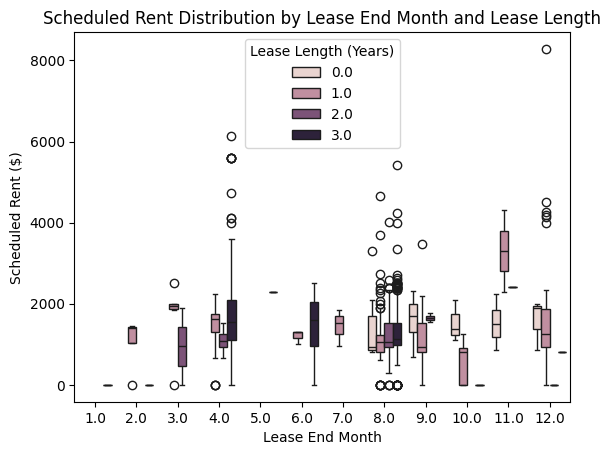

In [18]:
end_month_length = (
    filtered
    .groupby(["Lease Length Years", "End Month"])["Scheduled Rent"]
    .mean()
    .reset_index()
    .sort_values(["Lease Length Years", "Scheduled Rent"], ascending=[True, False])
)


sns.boxplot(
    data=filtered,
    x="End Month",
    y="Scheduled Rent",
    hue="Lease Length Years"
)
plt.title("Scheduled Rent Distribution by Lease End Month and Lease Length")
plt.xlabel("Lease End Month")
plt.ylabel("Scheduled Rent ($)")
plt.legend(title="Lease Length (Years)")
plt.show()

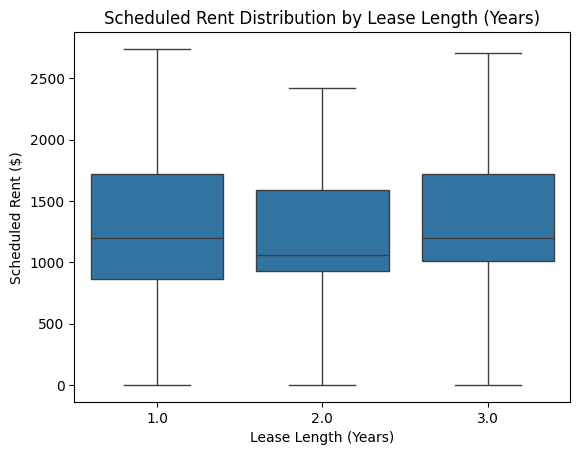

In [10]:
import seaborn as sns
start_pivot = leaseDatadf.pivot_table(
    index="Lease Length Years",
    columns="Start Month",
    values="Scheduled Rent",
    aggfunc="mean"
)

end_pivot = leaseDatadf.pivot_table(
    index="Lease Length Years",
    columns="End Month",
    values="Scheduled Rent",
    aggfunc="mean"
)

boxplot_data = leaseDatadf[leaseDatadf["Lease Length Years"].isin([1,2,3])]
boxplot = sns.boxplot(
    data=boxplot_data,
    x="Lease Length Years",
    y="Scheduled Rent",
    showfliers=False
)
boxplot.set_title("Scheduled Rent Distribution by Lease Length (Years)")
plt.xlabel("Lease Length (Years)")
plt.ylabel("Scheduled Rent ($)")
plt.show()